# Prologue
This notebooks holds my notes while going through 'Think DSP' by Allen B. Downey  http://greenteapress.com/thinkdsp/thinkdsp.pdf 

As I believe there is some added value in *not* using the books provided wrapper, and learning some things the *hard* way this notebook will include some reinvented wheels.

This notebook will also hold an attempt into translating some of the terms to my reality (do-re-mi-fa-sol-ish speak and Cello-sound).

In [250]:
import math
import matplotlib.pyplot as plot
import numpy as np
import wave

from IPython.display import Audio
from IPython.display import display

%matplotlib inline

# Chapter 1: Sounds and signals
## Exercise 1.2 : Question
Go to http://freesound.org and download a sound sample
that includes music, speech, or other sounds that have a well-defined pitch.
Select a roughly half-second segment where the pitch is constant. Compute
and plot the spectrum of the segment you selected. What connection can
you make between the timbre of the sound and the harmonic structure you
see in the spectrum?
Use high_pass, low_pass, and band_stop to filter out some of the harmonics.
Then convert the spectrum back to a wave and listen to it. How does
the sound relate to the changes you made in the spectrum?

## Exercise 1.2: Solution


To start I made 7 recordings on my cello:
* Open strings 
   * Open La (octave 3) string - 220 Hz
   * Open Re (octave 3) string - 127 Hz
   * Open Sol (octave 2) string - 98.2 Hz
   * Open Do (octave 2) string - 63.3 Hz
* Chords
   * La + Re
   * Re + Sol
   * Sol + Do

In [251]:
def normalize(ys, amp=1.0):
    """
    Normalize an array
    :param ys: The values to normalize
    :param amp: The amplitude of the result
    """
    maxval = max(abs(min(ys)), abs(max(ys)))
    return 1.0 * ys / maxval
    

In [252]:
def read_wave(filename='sound.wav'):
    """
    Reads a wave file.
    :returns: ys (for the first channel) and ts as numpy arrays and the samplerate as a dict.
    """
    wave_read = wave.open(filename, 'r')

    nchannels = wave_read.getnchannels()
    nframes = wave_read.getnframes()
    sampwidth = wave_read.getsampwidth()
    framerate = wave_read.getframerate()
    
    frames = wave_read.readframes(nframes)
    print("File: %s - %d channels - %d frames - samplewidth %d bit- framerate: %d Hz" % 
          (filename, nchannels, nframes, sampwidth * 2, framerate))
    
    wave_read.close()

    dtype_map = {1:np.int8, 2:np.int16, 4:np.int32}
    if sampwidth not in dtype_map:
        raise ValueError('sampwidth %d unknown' % sampwidth)
    
    ts = np.arange(0, 1.0 * nframes / framerate, 1.0/framerate)
    ys = np.frombuffer(frames, dtype=dtype_map[sampwidth])

    # if it's in stereo, just pull out the first channel
    if nchannels == 2:
        ys = ys[::2]

    # Normalize ys
    ys = normalize(ys)
    return { "ts" : ts, "ys": ys, "rate":framerate}



In [253]:
la = read_wave("samples/cello_open_string_la3_220hz.wav")
re = read_wave("samples/cello_open_string_re3_147hz.wav")
sol = read_wave("samples/cello_open_string_sol2_98hz.wav")
do  = read_wave("samples/cello_open_string_do2_65hz.wav")

File: samples/cello_open_string_la3_220hz.wav - 2 channels - 148480 frames - samplewidth 4 bit- framerate: 44100 Hz
File: samples/cello_open_string_re3_147hz.wav - 2 channels - 153600 frames - samplewidth 4 bit- framerate: 44100 Hz
File: samples/cello_open_string_sol2_98hz.wav - 2 channels - 153600 frames - samplewidth 4 bit- framerate: 44100 Hz
File: samples/cello_open_string_do2_65hz.wav - 2 channels - 131072 frames - samplewidth 4 bit- framerate: 44100 Hz


In [254]:
Audio(data=la["ys"], rate=la["rate"])

In [255]:
Audio(data=re["ys"], rate=re["rate"])

In [256]:
Audio(data=sol["ys"], rate=sol["rate"])

In [257]:
Audio(data=do["ys"], rate=do["rate"])

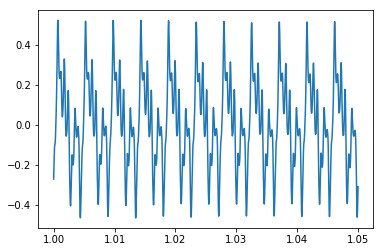

In [258]:
start = 1 * la["rate"]
end = int(start + 0.05 * la["rate"])
plot.plot(la["ts"][start:end], la["ys"][start:end])

Now read a chord combining do and sol and let's attempt to mix this ourselves

In [259]:
do_sol  = read_wave("samples/cello_open_strings_sol2_and_do2.wav")
Audio(data=do_sol["ys"], rate=do_sol["rate"])

File: samples/cello_open_strings_sol2_and_do2.wav - 2 channels - 147968 frames - samplewidth 4 bit- framerate: 44100 Hz


In [260]:
assert do["rate"] == sol["rate"]
num_samples = min(len(do["ys"]), len(sol["ys"]))
do_sol_artificial =  normalize(do["ys"][0:num_samples] + sol["ys"][0:num_samples])

In [261]:
Audio(data=do_sol_artificial, rate=do["rate"])

In [262]:
def rfft(ys, rate):
    num = len(ys)
    spacing = 1. / rate  # frequency spacing, inverse of samplerate
    
    amps = np.fft.rfft(ys)
    freqs = np.fft.rfftfreq(num, spacing)
    
    return (amps, freqs)
    
(la_amps, la_freqs) = rfft(la["ys"], la["rate"])


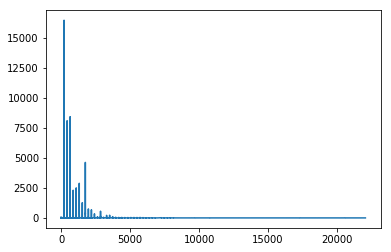

In [263]:
plot.plot(la_freqs, np.abs(la_amps))

This requires some zooming, however when zooming in, a peak is shown near 220 Hz.

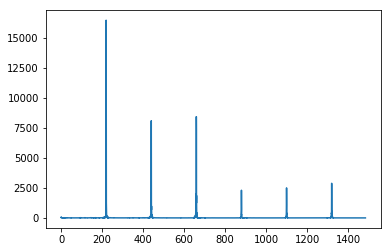

In [264]:
bins=5000
plot.plot(la_freqs[0:bins], np.abs(la_amps[0:bins]))

New let's search for all the peaks in the spectrum

In [265]:
def peaks(freqs, amps, num=10):
    """
    Given some frequencies and some amplitudes, returns the peaks and matching frequencies
    """
    freq_amp_list = list(zip(amps,freqs))
    freq_amp_list.sort(reverse=True)
    return (freq_amp_list[0:num])
    
la_peaks = peaks(la_freqs, np.abs(la_amps), 20)
for (amp, freq) in la_peaks:
    print("%d - %d " % (freq, amp))

220 - 16446 
659 - 8424 
440 - 8084 
660 - 7312 
219 - 7201 
439 - 7157 
1760 - 4618 
220 - 4069 
1760 - 3252 
220 - 3112 
1320 - 2880 
1100 - 2496 
219 - 2479 
439 - 2324 
880 - 2301 
659 - 2018 
660 - 1864 
659 - 1829 
1319 - 1662 
659 - 1563 


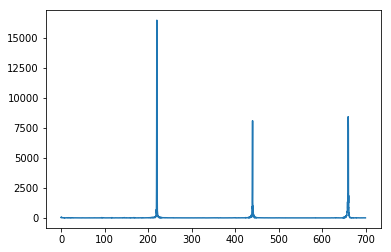

In [266]:
def find_freq_idx(freqs, freq):
    """
    Given a set of frequencies return the last index in the 
    freqs array which does not exceed freq.
    """
    i = 0
    while freq >= freqs[i]:
        i = i + 1
    return i - 1

idx_700 = find_freq_idx(la_freqs, 700)
plot.plot(la_freqs[0:idx_700], np.abs(la_amps[0:idx_700]))


Now let's try to remove the Cello-ish sound by applying a low pass

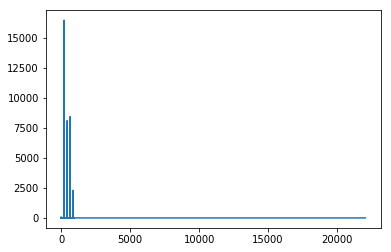

In [267]:
cutoff_freq = 1000
la_amps_lp = la_amps
la_amps_lp[la_freqs > cutoff_freq] = 0
plot.plot(la_freqs, np.abs(la_amps_lp))


And now bring this back to the time domain by applying an ifft

In [269]:
def ifft(amps):
    """
    Does the inverse fft
    """
    return np.fft.irfft(amps)

la_lp_ys = normalize(ifft(la_amps_lp))

In [270]:
Audio(data=la_lp_ys, rate=la["rate"])

That for sure ruined the instrument ;)

## Exercise 1.3: Question
Synthesize a compound signal by creating SinSignal and
CosSignal objects and adding them up. Evaluate the signal to get a Wave,
and listen to it. Compute its Spectrum and plot it. What happens if you add
frequency components that are not multiples of the fundamental?

## Exercise 1.3: Solution

Let's first add some function to create time and to generate and arbitrarily periodic function. 

In [120]:
def get_ts(start=0, stop=1, samplefreq=11025):
    """
    Get the times at which a waveform will need to be sampled.
    :param start: Start time
    :param stop: Stop time
    :param samplefreq: Sample frequency
    :return: The individual t values.
    """
    ts = np.arange(start, stop, 1.0/samplefreq)
    return ts

def get_signal(ts, func=np.sin, amplitude=1.0, freq=440, phase=0):
    """
    Generates a periodic function amplitude * func(2*PI*freq*t + phase)
    """
    return amplitude * func(2 * math.pi * freq * ts + phase)

ts = get_ts()
ys = get_signal(ts)

audio = Audio(data=ys, rate=11025)
audio

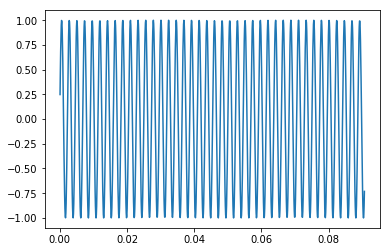

In [121]:
plot.plot(ts[1:1000], ys[1:1000])

Needless to say that this gives a very boring spectrum.

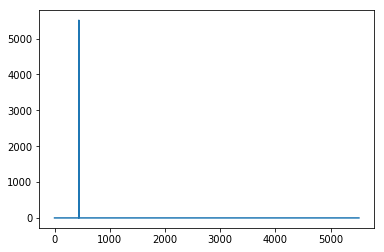

In [123]:
(amps_440, freqs_440) = rfft(ys, 11025)
plot.plot(freqs_440, np.abs(amps_440))

## Exercise 1.4
Write a function called stretch that takes a Wave and a stretch
factor and speeds up or slows down the wave by modifying ts and
framerate.

## Exercise 1.4 Solution